# Rescale rat model to match Long-Evans rat skeletal parameters

### Changes include
* Global scaling to approximate average rat size.
* Rescaling of long bones to measured lengths to preserve proportions. 

In [1]:
from dm_control import mjcf
from dm_control import viewer
from dm_control import mujoco
from dm_control import suite
import numpy as np
import re
import pandas as pd
from dm_control.mujoco.wrapper.mjbindings import mjlib
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Define useful parameters and functions

In [2]:
base_model_path = '/home/diego/code/olveczky/dm/stac/models/to_tune/rat_may17_radians.xml'
# temp_model_path is the model used by .../dm_control/suite/rat.py for easy iteration.
temp_model_path = '/home/diego/.envs/mujoco200_3.7/lib/python3.6/site-packages/dm_control/suite/rat_temp.xml'

def view_model():
    # Load an environment from the Control Suite.
    env = suite.load(domain_name="rat", task_name="stand")
    # Launch the viewer application.
    viewer.launch(env)

def load_model(model_path):
    return mjcf.from_path(model_path)

def write_model(model, save_path):
    s = model.to_xml_string()
    s = re.sub('rat_skin.*skn', 'rat_skin.skn', s)
    with open(save_path , 'w') as f:
        f.write(s)

In [3]:
# Save measured data (mm) and the bone-site pairs they correspond to 
lengths_path = '/home/diego/data/dm/stac/body_measurements/Length_measurements.xlsx'
length_data = pd.ExcelFile(lengths_path)
data = length_data.parse('Sheet1')
data = data.to_numpy()
data = data[5:,:]
measured_names = data[:,0]
data = data[:, 1:]
data = np.nanmean(data, axis=1)
print(data)


[39.766666666666666 37.62 22.753333333333334 39.16 37.66 22.5
 41.416666666666664 35.80833333333333 37.440000000000005 33.54
 28.933333333333334 17.503333333333334 16.354000000000003
 6.348000000000001 32.21666666666666 29.80333333333333 26.23333333333333
 16.759999999999998 14.720000000000002 5.63 31.5 28.74 26.839999999999996
 39.0 30.0 25.608333333333334 56.145 21.545 62.815999999999995 67.868
 132.40833333333333 53.4 18.458333333333332 8.225]


In [4]:
measured_lengths = {key: val for key, val in zip(measured_names, data)}
ideal_lengths = {}
for key, length in measured_lengths.items():
    if any([side in key for side in ['_L', '_R']]):
        right = key[:-2] + '_R'
        left = key[:-2] + '_L'
        length = (measured_lengths[right] + measured_lengths[left]) / 2.
        key = key[:-2]
    ideal_lengths[key] = np.round(length, decimals=1)
print(ideal_lengths)

{'ankle_claw': 39.5, 'ankle_toe': 37.6, 'ankle_pad': 22.6, 'tibia': 39.4, 'femur': 34.7, 'pelvis': 28.9, 'wrist_claw': 17.1, 'wrist_finger': 15.5, 'wrist_pad': 6.0, 'wrist_olecranon': 31.9, 'humerus': 29.3, 'scapula': 26.5, 'headcap_width': 39.0, 'headcap_length': 30.0, 'skull_width': 25.6, 'skull_length': 56.1, 'skull_height': 21.5, 'head_to_thoracic': 62.8, 'thoracic_to_sacral': 67.9, 'head_to_sacral': 132.4, 'width_at_midpoint': 53.4, 'ear': 18.5, 'eye': 8.2}


In [5]:
bone_lengths = {
    'humerus': ideal_lengths['humerus'],
    'radius': ideal_lengths['wrist_olecranon'],
    'femur': ideal_lengths['femur'],
    'tibia': ideal_lengths['tibia'],
    'metatarsal': ideal_lengths['ankle_pad'],
    'hand': 9.0}

# bone_lengths = {'humerus': 30.0,
#                 'radius': 29.6,
#                 'femur': 36.5,
#                 'tibia': 42.8,
#                 'metatarsal': 23.4,
#                 'hand': 9.0}

joint_pairs = {'humerus': ['shoulder_L', 'elbow_L'],
               'radius': ['elbow_L', 'wrist_L'],
               'femur': ['hip_L', 'knee_L'],
               'tibia': ['knee_L', 'ankle_L'],
               'metatarsal': ['ankle_L', 'toe_L'],
               'hand': ['wrist_L', 'finger_L']}

# skull_width = 38.8
# skull_length = 57

skull_dims = {'length': ideal_lengths['skull_length'], 'width': ideal_lengths['skull_width']}
skull_pairs = {'length': ['head', 'skull_T0_collision'],
              'width': ['eye_R_collision', 'eye_L_collision']}



base_model = load_model(base_model_path)
print(base_model.to_xml_string())
write_model(base_model, temp_model_path)
view_model()

<mujoco model="rat">
  <compiler angle="radian"/>
  <option timestep="0.001"/>
  <size njmax="2000" nconmax="1000"/>
  <visual>
    <quality shadowsize="2048"/>
    <headlight ambient="0.40000000000000002 0.40000000000000002 0.40000000000000002" diffuse="0.80000000000000004 0.80000000000000004 0.80000000000000004" specular="0.10000000000000001 0.10000000000000001 0.10000000000000001"/>
    <map znear="0.0002"/>
  </visual>
  <statistic meansize="0.003"/>
  <default>
    <default class="/">
      <mesh scale="1 1 1"/>
      <joint limited="true" solreflimit="0.01 1" solimplimit="0.98999999999999999 0.99990000000000001 0" armature="6e-08" damping="0.0001"/>
      <geom friction="0.69999999999999996 0.0050000000000000001 0.0001" solref="0.0050000000000000001 1"/>
      <site group="3" rgba="0 0 1 1"/>
      <general ctrllimited="true" ctrlrange="-1 1" gainprm="0.01"/>
      <default class="bone">
        <geom contype="0" conaffinity="0" group="0" rgba="0.5 0.5 0.5 1" density="1100.0"/>
 

## View the base model

In [6]:
# print([p for p in env.physics.named.model._asdict().keys() if 'jnt' in p])
# env.physics.named.data.xpos

In [7]:
def get_bone_distance(physics, joint_pair):
    joint0 = physics.named.data.site_xpos[joint_pair[0]].copy()
    joint1 = physics.named.data.site_xpos[joint_pair[1]].copy()
    length = np.sqrt(np.sum((joint0 - joint1)**2))
    return length

def get_bone_ratios(bone_dict):
    n_bones = len(bone_dict.keys())
    ratio_mat = np.zeros((n_bones,n_bones))
    ratio_dict = {}
    for i, (bone0, length0) in enumerate(bone_dict.items()):
        for j, (bone1, length1) in enumerate(bone_dict.items()):
            ratio = length0/length1
            ratio_mat[i, j] = ratio
            ratio_dict[bone0 + '-' + bone1] = ratio
            
    return ratio_dict, ratio_mat

def get_skull_dims(physics):
    atlas_pos = physics.named.data.xpos['vertebra_atlant'].copy()
    print(atlas_pos)
    T0_pos = physics.named.data.geom_xpos['skull_T0_collision'].copy()
    length = np.sqrt(np.sum((atlas_pos - T0_pos)**2))*1000
    
    eyeL_pos = physics.named.data.geom_xpos['eye_L_collision'].copy()
    eyeR_pos = physics.named.data.geom_xpos['eye_R_collision'].copy()
    width = np.sqrt(np.sum((eyeL_pos - eyeR_pos)**2))*1000
    return {'length': length, 'width': width}


## Apply global downscaling, and long-bone length matching

In [8]:
model = load_model(base_model_path)
write_model(base_model, temp_model_path)
# Globally scale down the model
def scale_model(model, global_scale_ratio=.82):
    for g in model.find_all('geom'):
        if g.pos is not None and 'eye' not in g.name:
            g.pos *= global_scale_ratio
    for b in model.find_all('body'):
        if b.pos is not None and 'eye' not in g.name:
            b.pos *= global_scale_ratio
    for s in model.find_all('site'):
        if s.pos is not None and 'eye' not in g.name:
            s.pos *= global_scale_ratio
    return model
model = scale_model(model)
write_model(model, temp_model_path)

env = suite.load(domain_name="rat", task_name="stand")
model_lengths = {k: get_bone_distance(env.physics, jp)*1000 for k, jp in joint_pairs.items()}
length_difference = {k: bone_lengths[k] - model_lengths[k] for k in model_lengths.keys()}
bone_ratios, bone_ratio_mat = get_bone_ratios(bone_lengths)
model_ratios, model_ratio_mat = get_bone_ratios(model_lengths)
print('Model lengths:', model_lengths)
print('Bone lengths:', bone_lengths)
ratio = [bone_lengths[k]/model_lengths[k] for k in model_lengths.keys()]
print('Ratio of bone_lengths to model_lengths', ratio)

# Scale particular arm and leg joints to match literature
def scale_arms_and_legs(model):
    env = suite.load(domain_name="rat", task_name="stand")
    model_lengths = {k: get_bone_distance(env.physics, jp)*1000 for k, jp in joint_pairs.items()}
    ratio = [bone_lengths[k]/model_lengths[k] for k in model_lengths.keys()]
    model_name_pairs = {'humerus': ['elbow', 'humerus', 'lower_arm'],
                   'radius': ['wrist', 'radius', 'ulna', 'hand'],
                   'femur': ['knee', 'upper_leg_L0_collision', 'upper_leg_R0_collision', 'lower_leg'],
                   'tibia': ['ankle', 'foot'],
                   'metatarsal': ['toe'],
                   'hand': ['finger', 'hand_L_collision', 'hand_R_collision']}
    for i, (bone, model_id) in enumerate(model_name_pairs.items()):
        for g in model.find_all('geom'):
            if any(part in g.name for part in model_id):
                if bone == 'radius' and any(part in g.name for part in ['hand_L_collision', 'hand_R_collision']):
                    continue
                if g.pos is not None:
                    g.pos *= ratio[i]
                if g.size is not None:
                    g.size *= ratio[i]
        for b in model.find_all('body'):
            if any(part in b.name for part in model_id):
                if b.pos is not None:
                    b.pos *= ratio[i]
        for s in model.find_all('site'):
            if any(part in s.name for part in model_id):
                if s.pos is not None:
                    s.pos *= ratio[i]
    return model
model = scale_arms_and_legs(model)
write_model(model, temp_model_path)


# Scale particular arm and leg joints to match literature
def scale_skull(model):
    env = suite.load(domain_name="rat", task_name="stand")
    model_dims = get_skull_dims(env.physics)
    ratio = [skull_dims[k]/model_dims[k] for k in model_dims.keys()]
    print('model_dims', model_dims)
    print(ratio)
    model_name_pairs = {'length': ['jaw', 'skull', 'eye'],
                       'width': ['jaw', 'skull', 'eye']}
    for i, (bone, model_id) in enumerate(model_name_pairs.items()):
        for g in model.find_all('geom'):
            if any(part in g.name for part in model_id):
                if g.pos is not None:
                    g.pos[i] *= ratio[i]
                if 'eye' in g.name:
                    continue
                if g.size is not None:
                    g.size[i] *= ratio[i]
        for b in model.find_all('body'):
            if any(part in b.name for part in model_id):
                if b.pos is not None:
                    b.pos[i] *= ratio[i]
        for s in model.find_all('site'):
            if any(part in s.name for part in model_id):
                if s.pos is not None:
                    s.pos[i] *= ratio[i]
    return model
model = scale_skull(model)
write_model(model, temp_model_path)
view_model()

Model lengths: {'humerus': 30.162181618709212, 'radius': 29.060874040537733, 'femur': 39.69160423186266, 'tibia': 42.94997217861235, 'metatarsal': 21.810933308755704, 'hand': 9.736960511371093}
Bone lengths: {'humerus': 29.3, 'radius': 31.9, 'femur': 34.7, 'tibia': 39.4, 'metatarsal': 22.6, 'hand': 9.0}
Ratio of bone_lengths to model_lengths [0.9714151439836696, 1.0976958213817622, 0.8742403002230981, 0.9173463450954197, 1.0361775757173828, 0.9243130840973988]
[7.12756162e-02 1.80628340e-08 7.07256124e-02]
model_dims {'length': 50.780195596778555, 'width': 23.0}
[1.1047614003983657, 1.1130434782608696]


## Check to make sure everything worked as planned

In [9]:
env = suite.load(domain_name="rat", task_name="stand")
model_lengths = {k: get_bone_distance(env.physics, jp)*1000 for k, jp in joint_pairs.items()}
length_difference = {k: bone_lengths[k] - model_lengths[k] for k in model_lengths.keys()}
bone_ratios, bone_ratio_mat = get_bone_ratios(bone_lengths)
model_ratios, model_ratio_mat = get_bone_ratios(model_lengths)
print('Model lengths:', model_lengths)
print('Bone lengths:', bone_lengths)
ratio = [bone_lengths[k]/model_lengths[k] for k in model_lengths.keys()]
print('Ratio of bone_lengths to model_lengths', ratio)


# model_dims = get_skull_dims(env.physics)
# ratio = [skull_dims[k]/model_dims[k] for k in model_dims.keys()]
# print('Ratio of bone_lengths to model_lengths', ratio)

Model lengths: {'humerus': 29.299999999999997, 'radius': 31.9, 'femur': 34.699999999999996, 'tibia': 39.400000000000006, 'metatarsal': 22.599999999999998, 'hand': 8.999999999999995}
Bone lengths: {'humerus': 29.3, 'radius': 31.9, 'femur': 34.7, 'tibia': 39.4, 'metatarsal': 22.6, 'hand': 9.0}
Ratio of bone_lengths to model_lengths [1.0000000000000002, 1.0, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 1.0000000000000007]


## View the model

In [10]:
view_model()

## Modify mass distribution by changing density

In [11]:
mass_dist_path = '/home/diego/data/dm/stac/body_measurements/Mass_distribution.xlsx'
mass_data = pd.ExcelFile(mass_dist_path)
data = mass_data.parse('Sheet1')
data = data.to_numpy()
parts = data[1:,0]
# masses = data[1:,1]
masses = data[1:,2:4]
print(masses)

#
real_ratios = {name: val/np.sum(masses[0, :]) for name,val in zip(parts, np.sum(masses, axis=1))}
print(real_ratios)

[[281 301]
 [21 26]
 [21 26]
 [8 10]
 [11 14]
 [12 13]
 [202 213]
 [176 187]
 [26 26]
 [78 71]
 [98 114]
 [122 129]
 [54 58]
 [22 32]
 [26 17]
 [74 80]
 [2.43 4.7]
 [23 21]
 [5.92 7.2]
 [1.78 2.3]
 [3.19 4.7]
 [6.25 4.7]
 [2.61 2.8]
 [0.53 0.5]
 [2.23 3.9]
 [6.08 6.7]
 [2.17 3.3]
 [0.53 0.5]
 [1.66 1.7]
 [9 9]
 [13 16]
 [1.81 1.6]
 [5 6]
 [13 18]]
{'total': 1.0, 'leg_L': 0.08075601374570447, 'leg_R': 0.08075601374570447, 'Tail': 0.030927835051546393, 'arm_R': 0.0429553264604811, 'arm_L': 0.0429553264604811, 'head_trunk_gut': 0.7130584192439863, 'trunk_gut': 0.6237113402061856, 'head': 0.08934707903780069, 'torso_half_liver': 0.25601374570446733, 'gut_half_liver': 0.3642611683848797, 'gut_liver': 0.43127147766323026, 'torso': 0.19243986254295534, 'intestines_stomach': 0.09278350515463918, 'liver': 0.07388316151202749, 'pelvis_kidneys': 0.2646048109965636, 'jaw': 0.01225085910652921, 'skull': 0.07560137457044673, 'tail_base_to_mid': 0.022542955326460484, 'tail_mid_to_tip': 0.007010309278

In [12]:
model_mass = .318
expected_masses = {}
for key, ratio in real_ratios.items():
    if any([side in key for side in ['_L', '_R']]):
        right = key[:-2] + '_R'
        left = key[:-2] + '_L'

        ratio = (real_ratios[right] + real_ratios[left]) / 2.
    expected_masses[key] = ratio*model_mass
# expected_masses['tail'] = expected_masses['tail_base_to_mid'] = expected_masses['tail_mid_to_tip']
# Keys are the keywords that correspond to geom(s) in the model.
# Values are keywords for the corresponding part in real data.
geom_mass_key_pairs = {
    'torso': 'torso',
    'pelvis': 'gut_liver',
    'upper_leg_L': 'upper_limb_L',
    'upper_leg_R': 'upper_limb_R',
    'lower_leg_L': 'lower_limb_L',
    'lower_leg_R': 'lower_limb_R',
    'foot_L': 'foot_L',
    'foot_R': 'foot_R',
    'skull': 'skull',
    'jaw': 'jaw',
    'scapula_L': 'scapula_L',
    'scapula_R': 'scapula_R',
    'upper_arm_L': 'humerus_L',
    'upper_arm_R': 'humerus_R',
    'lower_arm_R': 'forelimb_R',
    'lower_arm_L': 'forelimb_L',
    'hand_L': 'paw_L',
    'hand_R': 'paw_R',
    'vertebra_C': 'Tail'}
total = 0
for _, v in geom_mass_key_pairs.items():
    total += expected_masses[v]
    
print(total)

0.3161368041237113


In [13]:
print(expected_masses.keys())

dict_keys(['total', 'leg_L', 'leg_R', 'Tail', 'arm_R', 'arm_L', 'head_trunk_gut', 'trunk_gut', 'head', 'torso_half_liver', 'gut_half_liver', 'gut_liver', 'torso', 'intestines_stomach', 'liver', 'pelvis_kidneys', 'jaw', 'skull', 'tail_base_to_mid', 'tail_mid_to_tip', 'scapula_L', 'humerus_L', 'forelimb_L', 'paw_L', 'scapula_R', 'humerus_R', 'forelimb_R', 'paw_R', 'foot_L', 'lower_limb_L', 'upper_limb_L', 'foot_R', 'lower_limb_R', 'upper_limb_R'])


In [14]:
env = suite.load(domain_name="rat", task_name="stand")
model_masses = env.physics.named.model.body_mass
print(env.physics.named.model._asdict().keys())
[print(k ) for k in env.physics.named.model._asdict().keys() if 'class' in k]
print(model_masses)

dict_keys(['actuator_acc0', 'actuator_biasprm', 'actuator_biastype', 'actuator_cranklength', 'actuator_ctrllimited', 'actuator_ctrlrange', 'actuator_dynprm', 'actuator_dyntype', 'actuator_forcelimited', 'actuator_forcerange', 'actuator_gainprm', 'actuator_gaintype', 'actuator_gear', 'actuator_group', 'actuator_length0', 'actuator_lengthrange', 'actuator_trnid', 'actuator_trntype', 'actuator_user', 'body_dofadr', 'body_dofnum', 'body_geomadr', 'body_geomnum', 'body_inertia', 'body_invweight0', 'body_ipos', 'body_iquat', 'body_jntadr', 'body_jntnum', 'body_mass', 'body_mocapid', 'body_parentid', 'body_pos', 'body_quat', 'body_rootid', 'body_sameframe', 'body_simple', 'body_subtreemass', 'body_user', 'body_weldid', 'cam_bodyid', 'cam_fovy', 'cam_ipd', 'cam_mat0', 'cam_mode', 'cam_pos', 'cam_pos0', 'cam_poscom0', 'cam_quat', 'cam_targetbodyid', 'cam_user', 'dof_M0', 'dof_Madr', 'dof_armature', 'dof_bodyid', 'dof_damping', 'dof_frictionloss', 'dof_invweight0', 'dof_jntid', 'dof_parentid', '

In [15]:
part_mass = 0
env = suite.load(domain_name="rat", task_name="stand")
model_masses = env.physics.named.model.body_mass
model_masses_pre = np.copy(model_masses[:])
model_names = model_masses.axes.row.names
for model_kw, real_kw in geom_mass_key_pairs.items():
#     for g in model.find_all('geom'):
#         if model_kw in g.name:
#             part_mass += env.physics.named.model.body_mass[model_kw]
    for name in model_names:
        if model_kw in name:
            part_mass += model_masses[name]
    mass_ratio = expected_masses[real_kw]/part_mass
    for g in model.find_all('geom'):
         if model_kw in g.name:
            if g.density is None:
                g.density = 500.0 # taken from collision class
            g.density = g.density * mass_ratio
    part_mass = 0
            
write_model(model, temp_model_path)

FieldIndexer(body_mass):
 0               world [ 0       ]
 1               torso [ 0.0612  ]
 2          vertebra_1 [ 0.00209 ]
 3          vertebra_2 [ 0.00209 ]
 4          vertebra_3 [ 0.00209 ]
 5          vertebra_4 [ 0.00209 ]
 6          vertebra_5 [ 0.00209 ]
 7          vertebra_6 [ 0.00209 ]
 8              pelvis [ 0.137   ]
 9         upper_leg_L [ 0.0164  ]
10         lower_leg_L [ 0.00792 ]
11              foot_L [ 0.00185 ]
12               toe_L [ 0.000461]
13         upper_leg_R [ 0.0164  ]
14         lower_leg_R [ 0.00792 ]
15              foot_R [ 0.00185 ]
16               toe_R [ 0.000461]
17         vertebra_C1 [ 0.00271 ]
18         vertebra_C2 [ 0.00167 ]
19         vertebra_C3 [ 0.0016  ]
20         vertebra_C4 [ 0.00103 ]
21         vertebra_C5 [ 0.000423]
22         vertebra_C6 [ 0.00033 ]
23         vertebra_C7 [ 0.000237]
24         vertebra_C8 [ 0.000176]
25         vertebra_C9 [ 0.000212]
26        vertebra_C10 [ 0.00029 ]
27        vertebra_C11 [ 0.000

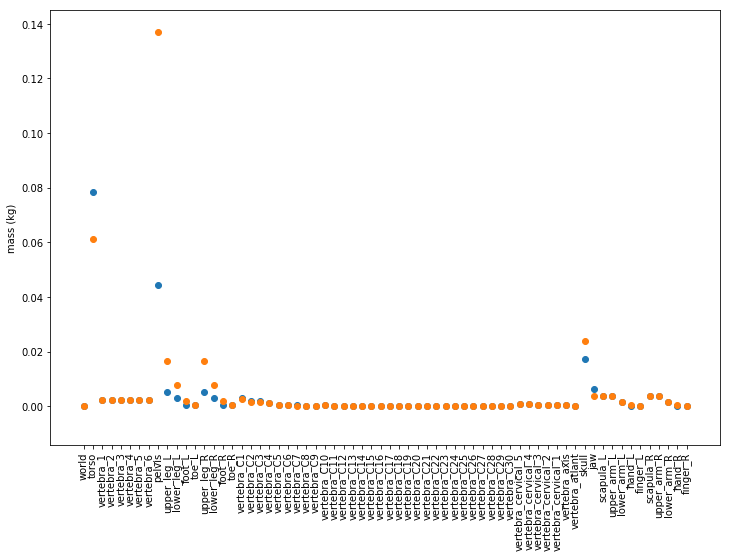

In [16]:
env = suite.load(domain_name="rat", task_name="stand")
model_masses_post = env.physics.named.model.body_mass
fig, ax = plt.subplots(figsize=(12,8))
x = range(len(model_names))
plt.scatter(x, model_masses_pre)
plt.scatter(x, model_masses_post[:])

plt.xticks(x)
_ = ax.set_xticklabels(model_names, rotation=90)

plt.ylabel('mass (kg)')
plt.rcParams['font.size'] = 10
print(model_masses_post)

vertebra_total = 0
for name in model_names:
    if 'vertebra_c' in name:
        vertebra_total += model_masses_post[name]
    if any([('vertebra_' + num) in name for num in ['1','2','3','4','5','6']]):
        vertebra_total += model_masses_post[name]
        
print(vertebra_total)

0.318
{'total': 0.318, 'leg_L': 0.025680412371134023, 'leg_R': 0.025680412371134023, 'Tail': 0.009835051546391754, 'arm_R': 0.01365979381443299, 'arm_L': 0.01365979381443299, 'head_trunk_gut': 0.22675257731958764, 'trunk_gut': 0.19834020618556703, 'head': 0.02841237113402062, 'torso_half_liver': 0.08141237113402061, 'gut_half_liver': 0.11583505154639175, 'gut_liver': 0.13714432989690722, 'torso': 0.0611958762886598, 'intestines_stomach': 0.02950515463917526, 'liver': 0.023494845360824742, 'pelvis_kidneys': 0.08414432989690722, 'jaw': 0.003895773195876289, 'skull': 0.024041237113402062, 'tail_base_to_mid': 0.007168659793814434, 'tail_mid_to_tip': 0.0022292783505154638, 'scapula_L': 0.0038302061855670106, 'humerus_L': 0.006482938144329898, 'forelimb_L': 0.0029723711340206185, 'paw_L': 0.0005627835051546392, 'scapula_R': 0.0038302061855670106, 'humerus_R': 0.006482938144329898, 'forelimb_R': 0.0029723711340206185, 'paw_R': 0.0005627835051546392, 'foot_L': 0.0018495360824742268, 'lower_lim

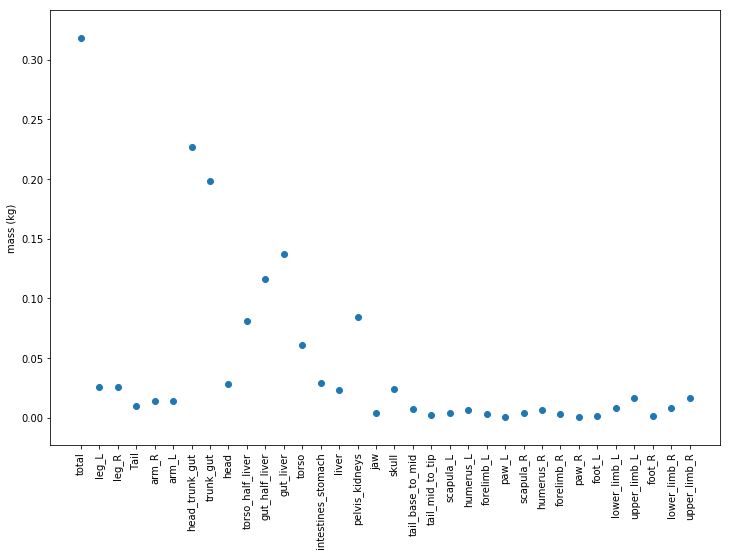

In [17]:
env = suite.load(domain_name="rat", task_name="stand")
model_masses_post = env.physics.named.model.body_mass
fig, ax = plt.subplots(figsize=(12,8))
x = range(len(expected_masses.keys()))
plt.scatter(x, expected_masses.values())

plt.xticks(x)
_ = ax.set_xticklabels(expected_masses.keys(), rotation=90)
print(expected_masses['total'])
plt.ylabel('mass (kg)')
plt.rcParams['font.size'] = 10
print(expected_masses)

In [18]:
mass = mjlib.mj_getTotalmass(env.physics.model.ptr)
print("Total mass is: %f kilograms" % (mass))
view_model()


Total mass is: 0.325231 kilograms
